# Maskinlæring

Maskinlæring deles ofte i to deler, såkalt supervised og unsupervised, hvor unsupervised metoder forsøker å finne struktur i data på egenhånd, mens supervised maskinlæring brukes for å trene modeller som kan predikere nye utfall.

Det er naturligvis supervised maskinlæring som er i fokus, alt pratet om Kunstig Intelligens refererer til supervised learning.

I denne notebooken skal vi først se litt på unsupervised maskinlæring og nye (dvs gamle) tilnærminger til utliggerdeteksjon på et datasett over lønninger i Boston. Deretter ser vi på supervised maskinlæring for tre ulike typer data

Med et tabulært (strukturert) datasett fra et nettsted for peer-to-peer lån forsøker vi å predikere manglende innfrielse av.

På et tekstdatasett fra offentlig elektronisk postjournal (aka websak) forsøker vi å bruke bag-of-words for å predikere om dokumenttitler kommer fra Statistisk Sentralbyrå eller Fylkesmannen i Sogn og Fjordane.

Til slutt ser vi på maskinlæring med bilder, med et datasett fra IBM som inneholder bilder med 6 forskjellige motiver.

## Outlier detection på lønnsdata

Vi må naturligvis begynne med å lese inn dataene, og sørge for at vi har riktige datatyper. For å konvertere datatyper allerede i innlesing bruker vi `converters` opsjonen i `pd.read_csv`, og spesifiserer vår egen funksjon for å konvertere de litt sære lønnsverdiene (som starter med $ og har komma som tusenskilletegn).

In [1]:
import pandas as pd

In [2]:
def forcefloat(f):
    try:
        rf = float(f.replace(",", ""))
    except:
        rf = 0
    return(rf)

In [3]:
import pandas as pd
emp = pd.read_csv('employeeearningscy18full.csv', 
                  converters={'REGULAR': forcefloat, 
                              'RETRO': forcefloat, 
                              'OTHER': forcefloat, 
                              'OVERTIME': forcefloat,
                              'INJURED': forcefloat,
                              'DETAIL': forcefloat,
                              'QUINN/EDUCATION INCENTIVE': forcefloat,
                             'TOTAL EARNINGS': forcefloat},
                  encoding='latin1')

In [5]:
testdf = emp[['REGULAR', 'RETRO', 'OTHER']].head(100)

In [7]:
testdf2 = (testdf - testdf.mean() ) / testdf.std()

In [8]:
testdf2

,REGULAR,RETRO,OTHER
0,0.101725,-0.857588,8.052905
1,-0.638961,0.580054,2.707749
2,-0.826172,-0.857588,2.634063
3,0.689683,-0.474825,2.023528
4,4.037857,-0.857588,1.113580
...,...,...,...
95,0.746360,1.273440,-0.523594
96,0.739774,2.221057,-0.524482
97,0.710634,1.038263,-0.533152
98,0.625194,0.850755,-0.535912


In [72]:
emp.dtypes

NAME                          object
DEPARTMENT_NAME               object
TITLE                         object
REGULAR                      float64
RETRO                        float64
OTHER                        float64
OVERTIME                     float64
INJURED                      float64
DETAIL                       float64
QUINN/EDUCATION INCENTIVE    float64
TOTAL EARNINGS               float64
POSTAL                        object
dtype: object

In [75]:
len(emp)

16.301795580110497

### Vi begynner med en SVM-basert modell

OneClassSVM er en 

In [131]:
from sklearn.svm import OneClassSVM

Innlesingsprosessen bør ha fjernet alle NaN, men for å være sikker kan vi fylle NaN med 0. I dette tilfellet kan vi føle oss relativt sikker på at manglende lønn tilsvarer 0 kroner, og å fylle NaN med 0 gir mening. Men generelt er dette en felle mange har gått i. Maskinlæringsmodeller takler ikke NaN, og det er generelt to tilnærminger til å håndtere NaN: Enten droppe rader med manglende verdier (`dropna()` er en pandas metode), eller fylle med en verdi. Sistnevnte er i praksis imputering, men ofte en relativt simpel form for imputering som f.eks. å bruke gjennomsnitt.

In [15]:
emp = emp.fillna(0)

In [16]:
emp.head()

,NAME,DEPARTMENT_NAME,TITLE,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS,POSTAL
0,"Williams,David C.",Boston Police Department,Police Officer,95184.68,0.00,503025.78,45176.88,"5,307.62",24610.0,4375.69,"677,680.65",02356
1,"Earley,John W",Boston Police Department,Police Lieutenant,26130.54,13001.47,204120.61,668.36,0,440.0,6532.63,"250,893.61",02131
2,"Bucelewicz,Helen",Boston Police Department,Police Officer,8676.89,0.00,200000.00,0.00,0,0.0,0.00,"208,676.89",02135
3,"Evans,William B",Boston Police Department,Commissioner (Bpd),149999.93,3461.56,165858.44,0.00,0,0.0,0.00,"319,319.93",02127
4,"Jones,Ronnie C",Boston Police Department,Police Officer,462149.98,0.00,114973.46,0.00,0,0.0,0.00,"577,123.44",02126


In [78]:
import math

In [82]:
import numpy as np

In [152]:
def lognorm(col):
    col = col.to_numpy()
    #col = np.log(col)
    col = np.nan_to_num(col, nan=0)
    col[col<0] = 0
    col = (col-col.mean()) / col.std()
    return(col)

In [124]:
logreg =  lognorm(emp['REGULAR'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
logreg.std()

1.0

Her ser vi flyttall in action - snittet skal pr def være 0, men grunnet avrunding er ikke resultatet helt nøyaktig. at tallet er av størrelsesorden e-16 er ikke en tilfeldighet: double-precision flyttall har en presisjon på 16 signifikante siffer.

In [129]:
logreg.mean()

1.685676475431714e-16

### Lage modellen
Det finnes noen hyperparameter som kan tunes, her ser vi ett av de, `gamma`, som i praksis angir hvor jevnt hyperplanet får være. For lineære hyperplan (kernels) blir dette argumentet ignorert. "scale" innebærer at parameteret blir beregnet basert på antallet parametre og variansen til disse.

In [153]:
emp['reg_norm'], emp['reg_ot'] = lognorm(emp['REGULAR']), lognorm(emp['OVERTIME'])

In [154]:
outlier_svm = OneClassSVM(gamma='scale').fit( [ emp['reg_norm'], emp['reg_ot'] ] )

In [155]:
type(outlier_svm)

sklearn.svm.classes.OneClassSVM

In [156]:
emp['outlier_status'] = outlier_svm.fit_predict( emp[['reg_norm', 'reg_ot']] )

In [157]:
emp.groupby('outlier_status')['outlier_status'].count()

outlier_status
-1    11790
 1    11815
Name: outlier_status, dtype: int64

In [158]:
emp.tail()

,NAME,DEPARTMENT_NAME,TITLE,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN/EDUCATION INCENTIVE,TOTAL EARNINGS,POSTAL,outlier_status,reg_norm,reg_ot,isoforest_status
23600,"Zingarelli,Lauren Marie",Environment Department,Dir CCE,79028.14,886.62,1146.98,0.00,0.0,0.0,0.0,81061.74,02128,1,0.456968,-0.373004,1
23601,"Zlab,Reilly",Dpt of Innovation & Technology,Prin Data Proc Systems Analyst,95796.61,1996.57,784.76,823.12,0.0,0.0,0.0,99401.06,02215,1,0.860141,-0.312680,1
23602,"Zlody,Maura T.",Environment Department,Environmental Asst,66792.43,741.30,0.00,0.00,0.0,0.0,0.0,67533.73,02215,1,0.162779,-0.373004,1
23603,"Zoran,Mor",ASD Office of Budget Mangmnt,Revenue Manager (OBM),77583.15,1746.62,1349.28,4226.15,0.0,0.0,0.0,84905.20,02113,1,0.422226,-0.063280,1
23604,"Zuares,David Jonathan",Law Department,Asst Corp Counsel II,49058.62,817.68,6607.06,0.00,0.0,0.0,0.0,56483.36,02127,1,-0.263605,-0.373004,1


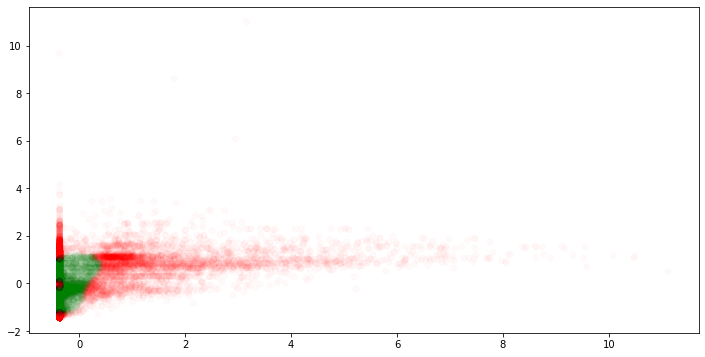

In [159]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6))

clrs = {-1: "red", 1: "green"}

cs = [clrs[e] for e in emp['outlier_status']]

plt.scatter( emp['reg_ot'], emp['reg_norm'], c=cs, alpha=0.02 )

In [147]:
from sklearn.ensemble import IsolationForest

isoforest = IsolationForest(contamination=0.1,
                                         random_state=42)

In [148]:
isoforest.fit(emp[['reg_norm', 'reg_ot']])

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

In [149]:
emp['isoforest_status'] = isoforest.fit_predict(emp[['reg_norm', 'reg_ot']])

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [150]:
emp[['REGULAR', 'OVERTIME', 'isoforest_status']].head()

,REGULAR,OVERTIME,isoforest_status
0,95184.68,45176.88,1
1,26130.54,668.36,1
2,8676.89,0.00,1
3,149999.93,0.00,1
4,462149.98,0.00,1


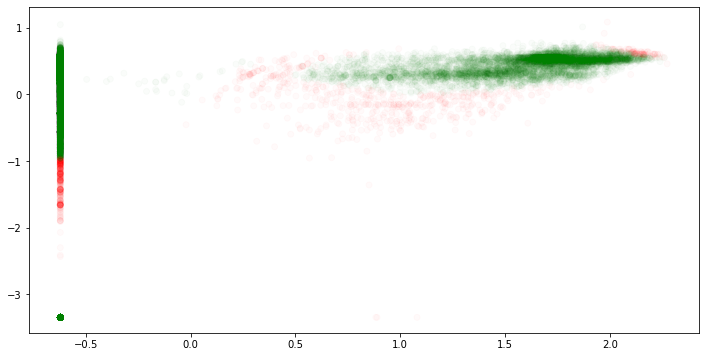

In [151]:
clrs = {-1: "red", 1: "green"}

cs = [clrs[e] for e in emp['isoforest_status']]

figure(num=None, figsize=(12, 6))


plt.scatter( emp['reg_ot'], emp['reg_norm'], c=cs, alpha=0.02 )

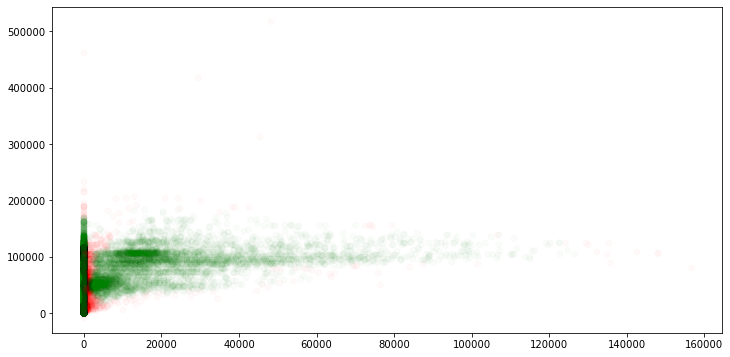

In [59]:
from sklearn.neighbors import LocalOutlierFactor
localout = LocalOutlierFactor(
        n_neighbors=35, contamination=0.1).fit(emp[['REGULAR', 'OVERTIME']])

emp['localout_status'] = localout.fit_predict(emp[['REGULAR', 'OVERTIME']])

cs = [clrs[e] for e in emp['localout_status']]

figure(num=None, figsize=(12, 6))
plt.scatter( emp['OVERTIME'], emp['REGULAR'], c=cs, alpha=0.02 )




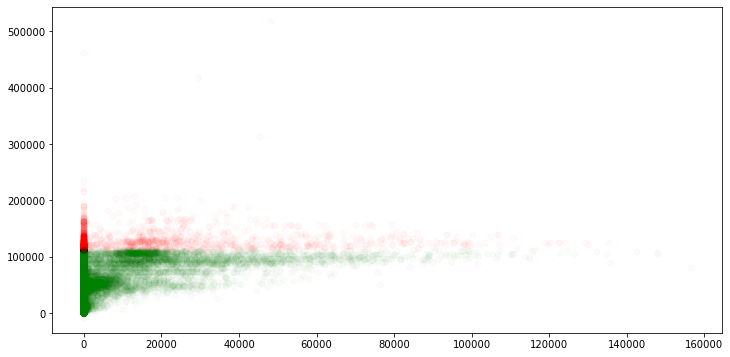

In [61]:
from sklearn.covariance import EllipticEnvelope

ellenv = EllipticEnvelope(contamination=0.1).fit(emp[['REGULAR', 'OVERTIME']])

emp['ellenv_status'] = ellenv.fit_predict(emp[['REGULAR', 'OVERTIME']])

cs = [clrs[e] for e in emp['ellenv_status']]

figure(num=None, figsize=(12, 6))
plt.scatter( emp['OVERTIME'], emp['REGULAR'], c=cs, alpha=0.02 )

In [62]:
emp.groupby('ellenv_status')['ellenv_status'].count()

ellenv_status
-1     2361
 1    21244
Name: ellenv_status, dtype: int64

**Now kids, remember to normalize...**